# **LIBRERÍAS NECESARIAS**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
import os

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

# **DATASETS**

In [ ]:
#@title **DIABETES PREDICTION DATASET**
diabetes_prediction_dataset_url = 'https://drive.google.com/uc?export=download&id=13n_OTsmto7H0Jw8xIGiWsaaYz8jttUit'
df_diabetes_prediction = pd.read_csv(diabetes_prediction_dataset_url)

# MODIFICAR EN [gender]
# PARA Female = 0
# PARA Male = 1
mapeo_en_generos = {'Female': 0, 'Male': 1}
df_diabetes_prediction['gender'] = df_diabetes_prediction['gender'].map(mapeo_en_generos)

# MODIFICAR EN [smoking_history]
# PARA never = 0
# PARA No Info = 1
# PARA current = 2
# PARA former = 3
# PARA ever = 4
# PARA not current = 5
mapeo_en_smoking_history = {'never': 0, 'No Info': 1, 'current': 2, 'former': 3, 'ever': 4, 'not current': 5}
df_diabetes_prediction['smoking_history'] = df_diabetes_prediction['smoking_history'].map(mapeo_en_smoking_history)

# MOSTRAR DATASET MODIFICADO
df_diabetes_prediction.head(5)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0.0,80.0,0,1,0,25.19,6.6,140,0
1,0.0,54.0,0,0,1,27.32,6.6,80,0
2,1.0,28.0,0,0,0,27.32,5.7,158,0
3,0.0,36.0,0,0,2,23.45,5.0,155,0
4,1.0,76.0,1,1,2,20.14,4.8,155,0


In [ ]:
#@title **DIABETES DATASET (TRAINING)**
diabetes_dataset_training_url = 'https://drive.google.com/uc?export=download&id=1I7b5tVM35r165K6uYxNuDGb1JXCEjDEP'
df_diabetes_training = pd.read_csv(diabetes_dataset_training_url)
df_diabetes_training.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
#@title **DATASETS COMBINADOS**
import pandas as pd

# RENOMBRAR COLUMNAS DEL SEGUNDO DATASET
df_diabetes_training_renamed = df_diabetes_training.rename(columns={
    'Pregnancies': 'pregnancies',
    'Glucose': 'blood_glucose_level',
    'BloodPressure': 'blood_pressure',
    'SkinThickness': 'skin_thickness',
    'Insulin': 'insulin',
    'BMI': 'bmi',
    'DiabetesPedigreeFunction': 'diabetes_pedigree_function',
    'Age': 'age',
    'Outcome': 'diabetes'
})

# ENCONTRAR COLUMNAS COMUNES
common_columns = df_diabetes_prediction.columns.intersection(df_diabetes_training_renamed.columns)

# CREAR DATAFRAME
df_combined = pd.concat([
    df_diabetes_prediction[common_columns],
    df_diabetes_training_renamed[common_columns]
], ignore_index=True)

# ELIMINAR COLUMNAS COMUNES DEL PRIMER DATASET
df_diabetes_prediction_clean = df_diabetes_prediction.drop(columns=common_columns.difference(['diabetes']))

# ELIMINAR COLUMNAS COMUNES DEL SEGUNDO DATASET
df_diabetes_training_clean = df_diabetes_training.drop(columns=['Glucose', 'BMI', 'Age'])


# IMPRIMIR DATASETS
print("=============TAMAÑOS DE CADA DATASET=============\n")
print("Dataset Combinado:", df_combined.shape)
print("Diabetes Prediction:", df_diabetes_prediction_clean.shape)
print("Diabetes Training:", df_diabetes_training_clean.shape)

print("\n=============DATASET COMBINADO=============\n")
print(df_combined.head())

print("\n=============DIABETES PREDICTION DATASET=============\n")
print(df_diabetes_prediction_clean.head())

print("\n=============DIABETES TRAINING DATASET=============\n")
print(df_diabetes_training_clean.head())

=============TAMAÑOS DE CADA DATASET=============

Dataset Combinado: (102460, 4)
Diabetes Prediction: (100000, 6)
Diabetes Training: (2460, 6)

=============DATASET COMBINADO=============

    age    bmi  blood_glucose_level  diabetes
0  80.0  25.19                  140         0
1  54.0  27.32                   80         0
2  28.0  27.32                  158         0
3  36.0  23.45                  155         0
4  76.0  20.14                  155         0

=============DIABETES PREDICTION DATASET=============

   gender  hypertension  heart_disease  smoking_history  HbA1c_level  diabetes
0     0.0             0              1                0          6.6         0
1     0.0             0              0                1          6.6         0
2     1.0             0              0                0          5.7         0
3     0.0             0              0                2          5.0         0
4     1.0             1              1                2          4.8         0

===

#**Genetic Algorithms (GAs)**

In [ ]:
#@title **Crossover, mutation**
import numpy as np
import pandas as pd

diabetes_prediction_dataset_url = 'https://drive.google.com/uc?export=download&id=13n_OTsmto7H0Jw8xIGiWsaaYz8jttUit'
df_diabetes_prediction = pd.read_csv(diabetes_prediction_dataset_url)

mapeo_en_generos = {'Female': 0, 'Male': 1}
df_diabetes_prediction['gender'] = df_diabetes_prediction['gender'].map(mapeo_en_generos)

mapeo_en_smoking_history = {'never': 0, 'No Info': 1, 'current': 2, 'former': 3, 'ever': 4, 'not current': 5}
df_diabetes_prediction['smoking_history'] = df_diabetes_prediction['smoking_history'].map(mapeo_en_smoking_history)

X = df_diabetes_prediction.drop(columns=['diabetes']).values
y = df_diabetes_prediction['diabetes'].values

def GA_initialize_population(n_individuals, n_features):
    population = np.random.randint(2, size=(n_individuals, n_features))
    return population

def GA_cross_over(parent1, parent2):
    crossover_point = np.random.randint(1, len(parent1) - 1)
    child = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
    return child

def GA_mutate(individual, mutation_prob):
    mutated_individual = np.copy(individual)
    for i in range(len(individual)):
        if np.random.random() < mutation_prob:
            mutated_individual[i] = 1 - mutated_individual[i]  # Cambiar entre 0 y 1
    return mutated_individual

# Initialize population
population = GA_initialize_population(100, X.shape[1])
print("Población inicial (primeros 5 individuos):\n", population[:5])

# Select parents and perform crossover
parent1 = population[np.random.randint(0, 100)]
parent2 = population[np.random.randint(0, 100)]
child = GA_cross_over(parent1, parent2)
print("\nPadre 1:", parent1)
print("Padre 2:", parent2)
print("Hijo (crossover):", child)

# Perform mutation
mutated_child = GA_mutate(child, 0.1)
print("\nHijo (mutación):", mutated_child)

Población inicial (primeros 5 individuos):
 [[0 0 1 1 0 1 1 0]
 [0 0 1 0 0 1 0 1]
 [0 1 1 1 0 1 0 0]
 [1 1 1 0 1 1 1 1]
 [1 1 0 1 0 1 1 1]]

Padre 1: [1 1 0 1 0 1 0 0]
Padre 2: [1 0 0 0 1 0 0 1]
Hijo (crossover): [1 1 0 1 0 0 0 1]

Hijo (mutación): [1 0 1 1 0 0 0 1]


In [ ]:
#@title **Funcion de aptitud**
from sklearn.linear_model import LogisticRegression
import numpy as np

def GA_fitness(individual, X, y):
    # Select features using the individual's genes
    selected_features_indices = np.where(individual == 1)[0]
    selected_features = X[:, selected_features_indices]

    # Remove rows with NaN values in the selected features
    mask = np.all(np.isfinite(selected_features), axis=1)  # Check for finite values (not NaN or Inf)
    selected_features = selected_features[mask]
    y_filtered = y[mask]  # Filter corresponding target values

    # Check if there are any samples left after filtering
    if selected_features.shape[0] == 0:
        return 0  # If no samples left, return 0 fitness

    # Create and fit the Logistic Regression model
    model = LogisticRegression(max_iter=1000)
    model.fit(selected_features, y_filtered)

    # Calculate accuracy
    accuracy = model.score(selected_features, y_filtered)
    return accuracy

# Supongamos que tienes un individuo mutado (mutated_child) para evaluar su aptitud
fitness_child = GA_fitness(mutated_child, X, y)
print("\nAptitud del hijo mutado:", fitness_child)


Aptitud del hijo mutado: 0.9396591386449561


        CARACTERÍSTICA  IMPORTANCIA
6          HbA1c_level     0.418633
7  blood_glucose_level     0.304786
5                  bmi     0.122546
1                  age     0.099637
4      smoking_history     0.024279
2         hypertension     0.013927
3        heart_disease     0.009256
0               gender     0.006936


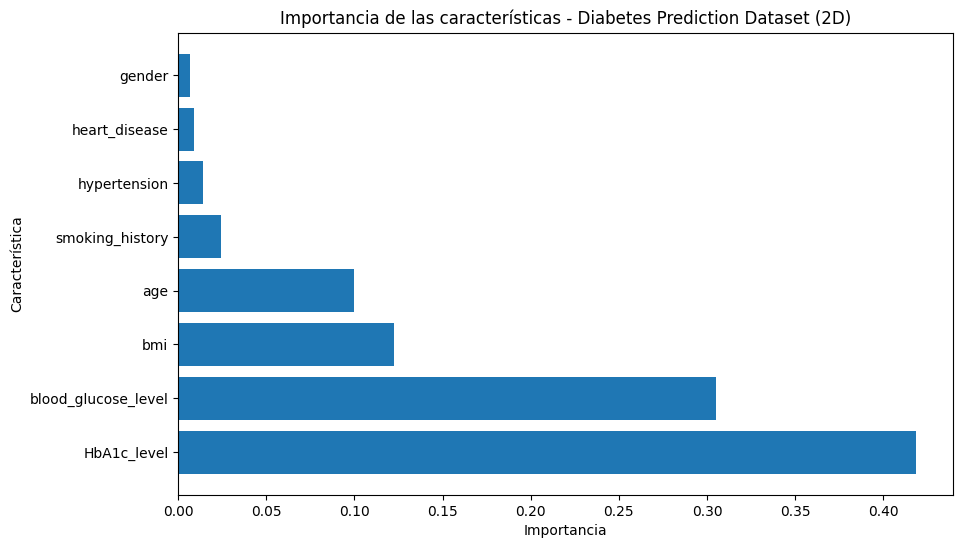

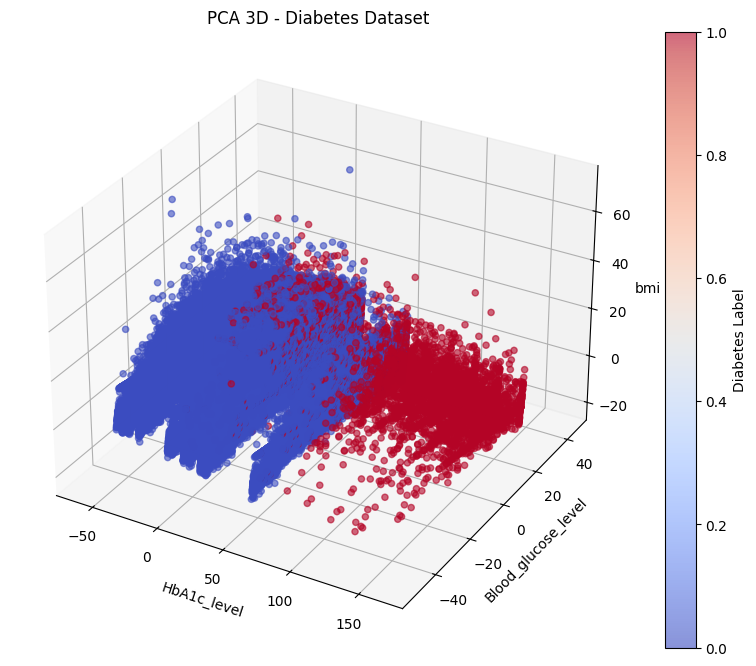

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer  # Import SimpleImputer for handling NaNs

# UTILIZAR RANDOM FOREST CLASSIFIER
modelo = RandomForestClassifier()
modelo.fit(df_diabetes_prediction.drop('diabetes', axis=1), df_diabetes_prediction['diabetes'])
importancias = modelo.feature_importances_
df_importancias = pd.DataFrame({'CARACTERÍSTICA': df_diabetes_prediction.drop('diabetes', axis=1).columns, 'IMPORTANCIA': importancias})
df_importancias = df_importancias.sort_values('IMPORTANCIA', ascending=False)

# MOSTRAR EL DATAFRAME
print(df_importancias)

# GRÁFICO DE BARRAS HORIZONTALES (2D)
plt.figure(figsize=(10, 6))
plt.barh(df_importancias['CARACTERÍSTICA'], df_importancias['IMPORTANCIA'])
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.title('Importancia de las características - Diabetes Prediction Dataset (2D)')
plt.show()

# Visualización 3D
# Create an imputer to fill NaN values with the mean of each column
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on your data and transform it
X_imputed = imputer.fit_transform(df_diabetes_prediction.drop('diabetes', axis=1))

pca = PCA(n_components=3)
# Apply PCA on the imputed data
X_pca_3d = pca.fit_transform(X_imputed)
y = df_diabetes_prediction['diabetes']

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=y, cmap='coolwarm', alpha=0.6)
ax.set_xlabel('HbA1c_level')
ax.set_ylabel('Blood_glucose_level')
ax.set_zlabel('bmi')
ax.set_title('PCA 3D - Diabetes Dataset')
fig.colorbar(scatter, label='Diabetes Label')
plt.show()

# **Predecir Diabetes**

In [ ]:
#--------------------------------------------------------#
#--------------------------------------------------------#
#--------------------------------------------------------#

#@title **Codigo del Decision Tree**
#@markdown **Ingresa los Valores para cada Característica:**

#--------------------------------------------------------#
#--------------------------------------------------------#
#--------------------------------------------------------#

# DATOS QUE INGRESA EL USUARIO
Edad =  25                                      #@param {type:"number"}
Género = "Masculino"                            #@param ["Masculino", "Femenino"]
Altura_Metros = 1.78                            #@param {type:"number"}
Peso_KG = 70                                    #@param {type:"number"}
Nivel_Glucosa =  450                            #@param {type:"number"}
Tiene_Hypertension = "Sí"                       #@param ["Sí", "No"]
Tiene_Problemas_Cardiacos = "Sí"                #@param ["Sí", "No"]
Historial_Tabaquismo = "Soy Fumador Actual"                #@param ["Nunca he Fumado", "Sin Información", "Soy Fumador Actual", "Antes Fumaba", "Alguna Vez he Fumado", "No Fumo"]
Nivel_HBA1C =  8.0                             #@param {type:"number"}

# OBTENER EL INDICE DE MASA CORPORAL A PARTIR DE LOS DATOS
BMI = Peso_KG/(Altura_Metros**2)

#--------------------------------------------------------#
#--------------------------------------------------------#
#--------------------------------------------------------#

# IMPORTAR LIBRERIAS
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

#--------------------------------------------------------#
#--------------------------------------------------------#
#--------------------------------------------------------#

# PARA EL DATASET COMBINADO

# SEPARAR CARACTERISTICAS Y ETIQUETAS
X_COMBINADO = df_combined.drop(columns='diabetes')
Y_COMBINADO = df_combined['diabetes']

# DIVIDIR EN CONJUNTO DE ENTRENAMIENTO Y PRUEBA
X_TRAIN_COMBINADO, X_TEST_COMBINADO, Y_TRAIN_COMBINADO, Y_TEST_COMBINADO = train_test_split(
    X_COMBINADO, Y_COMBINADO, test_size=0.2, random_state=42
)

# APLICAR SMOTE PARA BALANCEAR EL CONJUNTO DE ENTRENAMIENTO Y MITIGAR OVERFITTING
SMOTE_OBJETO = SMOTE(random_state=42)
X_TRAIN_COMBINADO_RES, Y_TRAIN_COMBINADO_RES = SMOTE_OBJETO.fit_resample(X_TRAIN_COMBINADO, Y_TRAIN_COMBINADO)

# ENTRENAR EL MODELO DECISION TREE CON DATOS BALANCEADOS
DTC_COMBINADO = DecisionTreeClassifier(random_state=42)
DTC_COMBINADO.fit(X_TRAIN_COMBINADO_RES, Y_TRAIN_COMBINADO_RES)

#--------------------------------------------------------#
#--------------------------------------------------------#
#--------------------------------------------------------#

# PARA EL PREDICTION DATASET

# SEPARAR CARACTERISTICAS Y ETIQUETAS
X1 = df_diabetes_prediction_clean.drop(columns='diabetes')
Y1 = df_diabetes_prediction_clean['diabetes']

# DIVIDIR EN CONJUNTO DE ENTRENAMIENTO Y PRUEBA
X1_TRAIN, X1_TEST, Y1_TRAIN, Y1_TEST = train_test_split(
    X1, Y1, test_size=0.2, random_state=42
)

# ELIMINAR FILAS CON NANS ENTRENAMIENTO
X1_TRAIN = X1_TRAIN.dropna()
Y1_TRAIN = Y1_TRAIN[X1_TRAIN.index]

# ELIMINAR FILAS CON NANS TEST
X1_TEST = X1_TEST.dropna()
Y1_TEST = Y1_TEST[X1_TEST.index]

# APLICAR SMOTE PARA BALANCEAR EL CONJUNTO DE ENTRENAMIENTO Y MITIGAR OVERFITTING
X1_TRAIN_RES, Y1_TRAIN_RES = SMOTE_OBJETO.fit_resample(X1_TRAIN, Y1_TRAIN)

# ENTRENAR EL MODELO RANDOM FOREST CON DATOS BALANCEADOS
DTC1 = DecisionTreeClassifier(random_state=42)
DTC1.fit(X1_TRAIN_RES, Y1_TRAIN_RES)

#--------------------------------------------------------#
#--------------------------------------------------------#
#--------------------------------------------------------#

# MAPEAR ALGUNAS VARIABLES
mapeo_en_generos = {'Femenino': 0, 'Masculino': 1}
mapeo_en_hypertension = {'No': 0, 'Sí': 1}
mapeo_en_cardiopatia = {'No': 0, 'Sí': 1}
mapeo_en_smoking_history = {"Nunca he Fumado": 0, "Sin Información": 1, "Soy Fumador Actual": 2, "Antes Fumaba": 3, "Alguna Vez he Fumado": 4, "No Fumo": 5}

# DICCIONARIO PARA DATASET COMBINADO
datos_usuario_combinado = {
    'age': Edad,
    'bmi': BMI,
    'blood_glucose_level': Nivel_Glucosa
}

# CREAR DATAFRAME CON ESOS DATOS.
df_usuario_combinado = pd.DataFrame([datos_usuario_combinado])

# DICCIONARIO PARA DATASET PREDICTION
datos_usuario_prediction = {
    'gender': mapeo_en_generos[Género],
    'hypertension': mapeo_en_hypertension[Tiene_Hypertension],
    'heart_disease': mapeo_en_cardiopatia[Tiene_Problemas_Cardiacos],
    'smoking_history': mapeo_en_smoking_history[Historial_Tabaquismo],
    'HbA1c_level': Nivel_HBA1C
}

# CREAR DATAFRAME CON ESOS DATOS.
df_usuario_prediction = pd.DataFrame([datos_usuario_prediction])

#--------------------------------------------------------#
#--------------------------------------------------------#
#--------------------------------------------------------#

# PREDICCION DATASET COMBINADO
prediccion_combinado = DTC_COMBINADO.predict(df_usuario_combinado)[0]

# PREDICCION PREDICTION DATASET
prediccion_prediction = DTC1.predict(df_usuario_prediction)[0]

#--------------------------------------------------------#
#--------------------------------------------------------#
#--------------------------------------------------------#

# MOSTRAR RESULTADO
if prediccion_combinado == 0 :
    print("No tiene diabetes.")
else:
    print("Tiene diabetes.")

Tiene diabetes.
